# Best Model & Conclusions

Let's combine everything we've learned so far and determine the best model.

## Imports and Functions

In [ ]:
import pickle
import random

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# prep for models and search parameter space
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, 
    classification_report, 
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score, 
)

# stopwords
import nltk
import spacy
from gensim.parsing.preprocessing import STOPWORDS

### Functions

In [2]:
def evaluate_model(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                   short_name='short', return_misclassified=False, return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = "Model details here"
        string to form the subtitle of figures
    short_name : str, default = "short"
        string used name saved figures and scoring dictionary
    return_misclassified : bool, default = False
        returns Data Frame of misclassified results when True: true value, predicted value, probability calculated by model
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res : pandas Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for misclassified results, only returned if `return_misclassified == True`
    res_all : panda Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)

    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }
    
    # misclassified results
    results = []
    for i in range(len(y_test)):
        if preds[i] != y_test.iloc[i]:
            results.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})

    res = pd.DataFrame(results)

    # probability histogram of misclassified results
    fig_hist = px.histogram(
        res, 
        x='prob_fraud', 
        title = 'Probability Distribution of Misclassified Job Ads', 
        subtitle= f'Model: {fig_subtitle}'
    )

    fig_hist.show()


    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');

    # save figures, if save_figs is True
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_hist.write_image(f'../images/hist_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    # return options
    if return_all_results == True and return_misclassified == True:
        return scores, res, res_all
    elif return_all_results == True:
        return scores, res_all
    elif return_misclassified == True:
        return scores, res
    else:
        return scores

In [3]:
def evaluate_model_noprob(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                          short_name='short', return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = 'Model details here'
        string to form the subtitle of figures
    short_name : str, default = 'short'
        string used name saved figures
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res_all : panda Data Frame, optional
        contains the true and predicted values for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    
    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }

    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');
    
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    if return_all_results == True:
        return scores, res_all
    else:
        return scores

In [4]:
def save_model (model, filename):
    '''
    pickles model as filename.pkl in the models directory
    '''
    with open(f'./models/{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)

### Stopwords

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erindepree/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# nltk stopwords
stopwords_nltk = list(nltk.corpus.stopwords.words('english'))

# spacy stopwords
nlp = spacy.load("en_core_web_sm")
stopwords_spacy = list(nlp.Defaults.stop_words)

# gensim stopwords
stopwords_gensim = list(STOPWORDS)

In [7]:
def determine_stopword_list(stopwords):
    """
    takes a list (or anything that be forced into a set) and compares it with our other stopwords lists to determine which list it is

    Parameters
    ----------
    stopwords : list (or set / anything that can be forced into a set) of strings
        list of stopwords used in model

    Returns
    -------
    list_name : string
        name of likely list
    """
    
    if len(set(stopwords).difference(set(stopwords_gensim))) == 0:
        list_name = 'Gensim'
    elif len(set(ridge.best_params_['ct__cv__stop_words']).difference(set(stopwords_spacy))) == 0:
        list_name = 'spaCy'
    elif len(set(ridge.best_params_['ct__cv__stop_words']).difference(set(stopwords_nltk))) == 0:
        list_name = 'NLTK'
    else:
        list_name = 'not Gensim, spaCy, or NLTK default lists'

    return list_name

### Functions to Style Tables

In [8]:
def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

In [9]:
def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

## Data

### Data Import

In [10]:
df = pd.read_csv('../data/clean/job_ads.csv')

In [11]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,job_ad
0,0,1,0,Other,Internship,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,Full-time,Not Applicable,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,NaN,NaN,0,Valor Services provides Workforce Solutions th...
3,0,1,0,Full-time,Mid-Senior level,0,Our passion for improving quality of life thro...
4,0,1,1,Full-time,Mid-Senior level,0,SpotSource Solutions LLC is a Global Human Cap...


### Set Up Data

In [12]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

In [13]:
X = X.fillna('')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1613)

## Logistic Regression

In [19]:
model_log_cv_ridge = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty='l2', C=0.1, max_iter= 500))
])

In [42]:
ridge = GridSearchCV(
    model_log_cv_ridge, 
    param_grid={
        'ct__cv__stop_words': [None, 'english', stopwords_gensim],
        'log__C': range(8,14)
    },
    scoring='f1',
)

In [43]:
ridge.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('log',
                                        LogisticRegression(C=0.1,
                                                           max_iter=500))]),
             param_grid={'ct__cv__stop_words': [None, 'english',
                                                ['serious', 'could', 'an', 'me',
                                                 'well', 'nowhere', 'thus',
                                                 'alone', 'go', 'yet',
                                                 'moreover', 'whether',
                                                 'himself', 'over', 'keep',
                                                 'those', 'mine', 'my',
                                                 'thereby', 'thru', 'two',
                                                 'every', 'for', 'again',
                                                 'anything', 'only', 'found',
                                                 'already', 'another', 'made', ...]],
                         'log__C': range(8, 14)},
             scoring='f1')

In [44]:
ridge.best_params_['log__C']

9

In [45]:
determine_stopword_list(ridge.best_params_['ct__cv__stop_words'])

'Gensim'

In [46]:
ridge.best_score_

0.8290746176802364


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



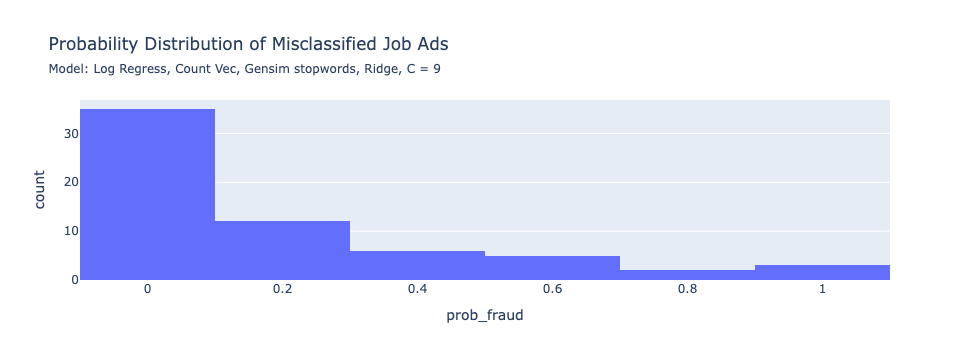

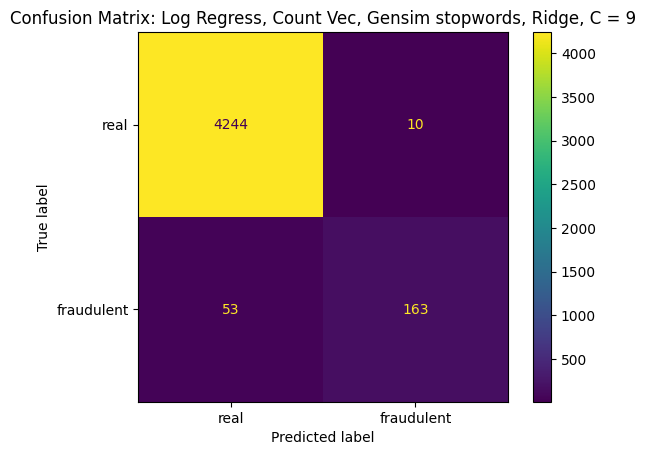

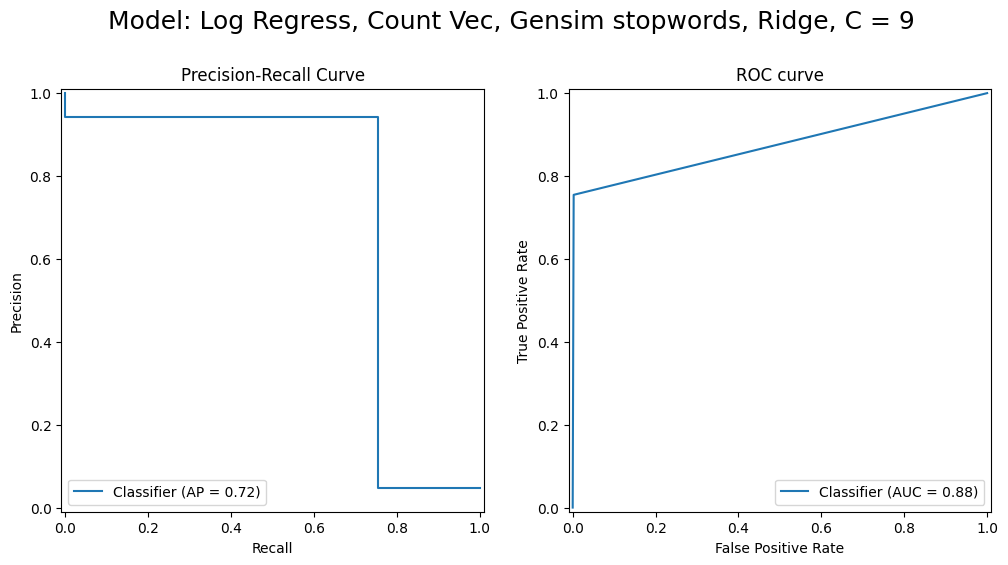

In [52]:
scores_log_cv_ridge_best = evaluate_model(
    ridge, X_test, y_test, 
    fig_subtitle= 'Log Regress, Count Vec, Gensim stopwords, Ridge, C = 9', 
    short_name='log_ridge_best', 
    save_figs=False,
    return_misclassified = False,
    return_all_results = False
)

In [382]:
#save_model(ridge_2, 'model_ridge_best_1')

In [383]:
#res_log_cv_ridge_best.to_csv('../data/results/res_log_cv_ridge_best.csv')

In [53]:
scores_log_cv_ridge_best

{'model': 'log_ridge_best',
 'accuracy': 0.9859060402684564,
 'precision': 0.9421965317919075,
 'recall': 0.7546296296296297,
 'f1_score': 0.8380462724935732,
 'roc_auc_score': 0.8761394504518624}

## SVC

In [31]:
model_svc_cv = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('svc', LinearSVC())
])

By default, the linear SVC model employs $\ell_2$ penalty (Ridge regularization) and uses a squared hinge loss function.

In [32]:
model_svc_cv.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                     transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                    'job_ad'),
                                   ('ohe', OneHotEncoder(drop='first'),
                                    ['employment_type', 'required_experience'])])),
  ('svc', LinearSVC())],
 'transform_input': None,
 'verbose': False,
 'ct': ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                   transformers=[('cv', CountVectorizer(ngram_range=(1, 2)),
                                  'job_ad'),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['employment_type', 'required_experience'])]),
 'svc': LinearSVC(),
 'ct__force_int_remainder_cols': False,
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': None,
 

In [33]:
params_svc = {
    'ct__cv__stop_words': [None, 'english', stopwords_gensim],
    'svc__C': [0.01, 0.005, 0.02],
    'svc__max_iter': [10000]
}

In [34]:
grid_svc = GridSearchCV(model_svc_cv, param_grid= params_svc, scoring='f1')

In [35]:
grid_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('svc', LinearSVC())]),
             param_grid={'ct__cv__stop_words': [None, 'english',
                                                ['serious', 'could', 'an', 'me',
                                                 'well', 'nowhere', 'thus',
                                                 'alone', 'go', 'yet',
                                                 'moreover', 'whether',
                                                 'himself', 'over', 'keep',
                                                 'those', 'mine', 'my',
                                                 'thereby', 'thru', 'two',
                                                 'every', 'for', 'again',
                                                 'anything', 'only', 'found',
                                                 'already', 'another', 'made', ...]],
                         'svc__C': [0.01, 0.005, 0.02],
                         'svc__max_iter': [10000]},
             scoring='f1')

In [36]:
grid_svc.best_params_

{'ct__cv__stop_words': None, 'svc__C': 0.02, 'svc__max_iter': 10000}

In [37]:
grid_svc.best_score_

0.8259977108021083


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/2419598850.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



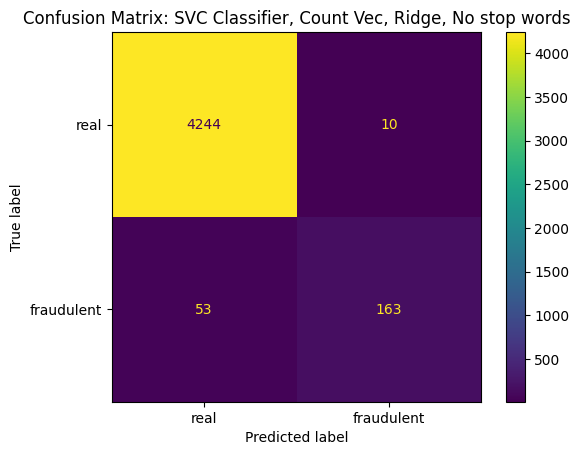

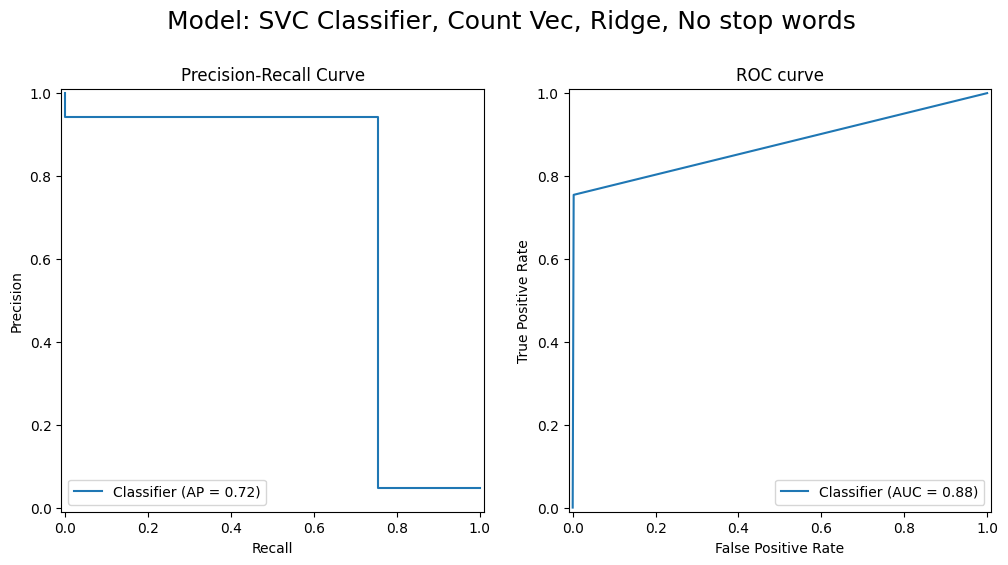

In [49]:
scores_svc_cv = evaluate_model_noprob(
    grid_svc, X_test, y_test, 
    fig_subtitle= 'SVC Classifier, Count Vec, Ridge, No stop words', 
    short_name='svc_cv_ridge', 
    save_figs= False,
    return_all_results = False
)

In [64]:
#save_model(grid_svc, 'grid_svc_cv')

In [65]:
#res_svc_cv.to_csv('../data/results/res_svc_cv.csv')

In [39]:
scores_svc_cv

{'model': 'svc_cv_ridge',
 'accuracy': 0.9859060402684564,
 'precision': 0.9421965317919075,
 'recall': 0.7546296296296297,
 'f1_score': 0.8380462724935732,
 'roc_auc_score': 0.8761394504518624}

## Summary, So Far

In [54]:
pd.DataFrame([scores_svc_cv, scores_log_cv_ridge_best]).style.apply(
    highlight_max, props='color:white;background-color:darkblue', axis=0, 
    subset=['accuracy','precision','recall', 'f1_score','roc_auc_score']
)

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,svc_cv_ridge,0.985906,0.942197,0.754630,0.838046,0.876139
1,log_ridge_best,0.985906,0.942197,0.754630,0.838046,0.876139


## Data Split -- Does it Matter?

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1613)

In [58]:
def results_split(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1613)
    model = Pipeline([
        ('ct', ColumnTransformer([
            ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
            ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
        ], remainder= 'passthrough', force_int_remainder_cols=False)),
        ('log', LogisticRegression(penalty='l2', C=0.1, max_iter= 500))
    ])
    ridge = GridSearchCV(
        model, 
        param_grid={
            'ct__cv__stop_words': [None, stopwords_gensim],
            'log__C': [9, 10, 11]
        },
        scoring='f1',
    )

    ridge.fit(X_train, y_train)

    best_params = ridge.best_params_

    results = evaluate_model(
        ridge, X_test, y_test, 
        fig_subtitle= 'Log Regress, Count Vec, Gensim stopwords, Ridge', 
        short_name='log_ridge', 
        save_figs=False,
        return_misclassified = False,
        return_all_results = False
    )

    results['random_state'] = num
    results['C'] = best_params['log__C']

    if best_params['ct__cv__stop_words'] == None:
        results['stop_words'] = 'None'
    else:
        results['stop_words'] = 'Gensim'

    return results

In [ ]:
scores = []

for i in range(10):
    scores.append(results_split(random.randint(0, 1e12)))


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.75      0.84       216

    accuracy                           0.99      4470
   macro avg       0.96      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_18991/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



In [ ]:
pd.DataFrame(scores)